In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [13]:
import ta
import talib
from tech_indicators import stoch,stoch_signal

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [15]:
np.random.seed(999)

In [16]:
## TODO 
# normalise/scale the high,low,open and close prices
# normalise/scale the computed tech indicators
# generate pattern based features using TA-Lib (candlesticks etc)
# generate features based on the hourly trading data to identify, volatility and activity
# generate features based on signal crossovers and trend reversals

## Preparing Data 


In [17]:
fcpo_data_daily=pd.read_hdf('processed_dta.h5','fcpo_data_daily')
fcpo_data_hourly=pd.read_hdf('processed_dta.h5','fcpo_data_hourly')

## Technical Indicators

* Momentum Indicators - Leading Indicators; Relative Change
 * MACD Diff - Crossover strategy
 * Relative Strength Index: An oscillator between 0 and 100; > 70-overbought, < 30-oversold
* Trend Indicators - Lagging Indicators
 * ADX - indicates the strength of trend ( < 20 no trend , > 20 trend)
* Volume Indicators
 * Force index
 * On Balance Volume (OBV)
* Volatility Indicators
 * Bollinger Bands: Based on the moving average and n*standard deviations
 * Average True Range (ATR): Based on the current period's high, low and previous closing prices

Support and Resistance represents the lowest and highest values of the price in the given time period. It forms a basis for when to enter and exit positions and to be used together with other TA for devising features.

Infer the signals from the context

* Signal line crossovers ( switching between +/- values of macd diff)
* Center line crossovers ( switching between +/- values of macd)
* Divergence: Track the higher-highs/lower-lows of the indicators and price indexes to generate reversal flags

Momentum indicators work during sidwards moving market conditions, when the market is trending upwards/downwards a different strategy needs to be formulated.
* Trend look-back period should be atleast 2-3 times higher than the momentum look-back periods, to detect longer trend and then use the momentum for decisions
* Look for occassional oversold conditions in upward trend, or overbrought in downward trend


### Feature Engineering

* Trend indicators based on close > sma(close,30)
* Check for Trend to continue atleast 3 continuous periods

In [18]:
def generate_tech_ind(fcpo_df):
    fcpo_df_tind=pd.DataFrame({
        'ema_slow':ta.trend.ema_slow(fcpo_df['Close'],n_slow=25).bfill(),
        'ema_fast':ta.trend.ema_fast(fcpo_df['Close'],n_fast=10).bfill(),
        'macd': ta.trend.macd(fcpo_df['Close']).bfill(),
        'macd_signal': ta.trend.macd_signal(fcpo_df['Close']).bfill(),
        'stoch' : stoch(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']).bfill(),
        'stoch_signal' : stoch_signal(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']).bfill(),
        'rsi':ta.momentum.rsi(fcpo_df['Close']).bfill(),
        'adx': ta.trend.adx(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']).bfill(),
        'atr': ta.volatility.average_true_range(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']).bfill(),
        #'find' : ta.volume.force_index(fcpo_df['Close'],fcpo_df['Volume']).bfill(),
        'eom': ta.volume.ease_of_movement(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close'],fcpo_df['Volume'],n=10,fillna=True).bfill()
       })
    return fcpo_df_tind

In [19]:
fcpo_daily_tind=generate_tech_ind(fcpo_data_daily[['Open','High','Low','Close','Volume']].shift(1))

### Momentum Indicators - MACD, Stoch, RSI

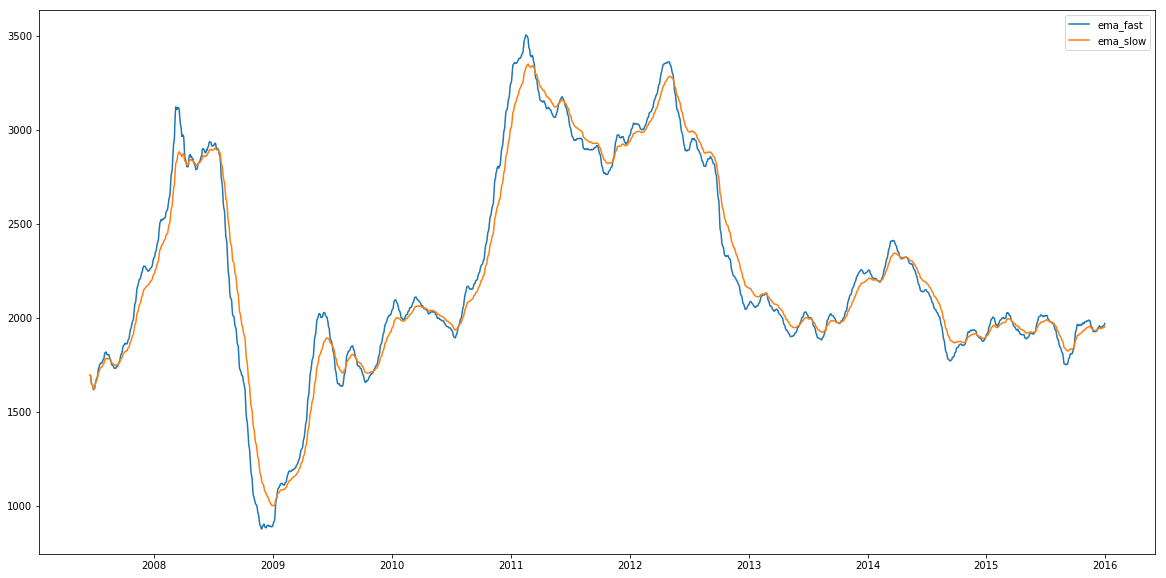

In [20]:
plt.figure(figsize=(20,10))
plt.plot(fcpo_daily_tind['2007-01-01':'2016-01-01']['ema_fast'])
plt.plot(fcpo_daily_tind['2007-01-01':'2016-01-01']['ema_slow'])
#plt.plot(fcpo_data_daily['2007-01-01':'2016-01-01']['Close'])
plt.legend()
plt.show()

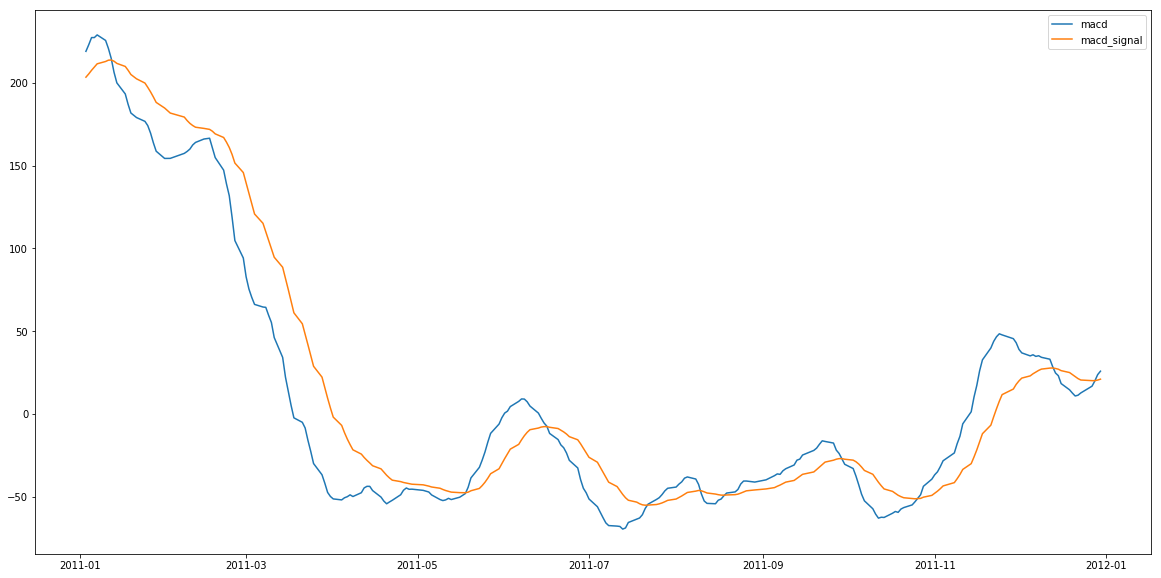

In [21]:
plt.figure(figsize=(20,10))
plt.plot(fcpo_daily_tind['2011-01-01':'2012-01-01']['macd'])
plt.plot(fcpo_daily_tind['2011-01-01':'2012-01-01']['macd_signal'])
plt.legend()
plt.show()

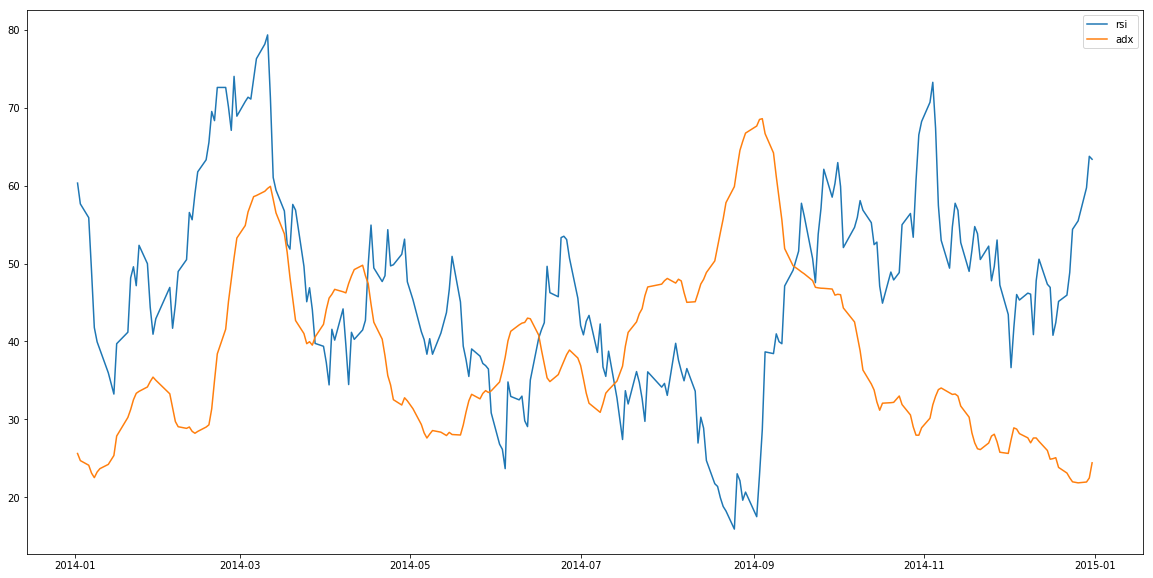

In [22]:
plt.figure(figsize=(20,10))
plt.plot(fcpo_daily_tind['2014-01-01':'2015-01-01']['rsi'])
plt.plot(fcpo_daily_tind['2014-01-01':'2015-01-01']['adx'])
plt.legend()
plt.show()

## Representing data in Candle sticks format

In [23]:
selected_fcpo_data=fcpo_data_daily['2016-01-01':'2017-01-01']

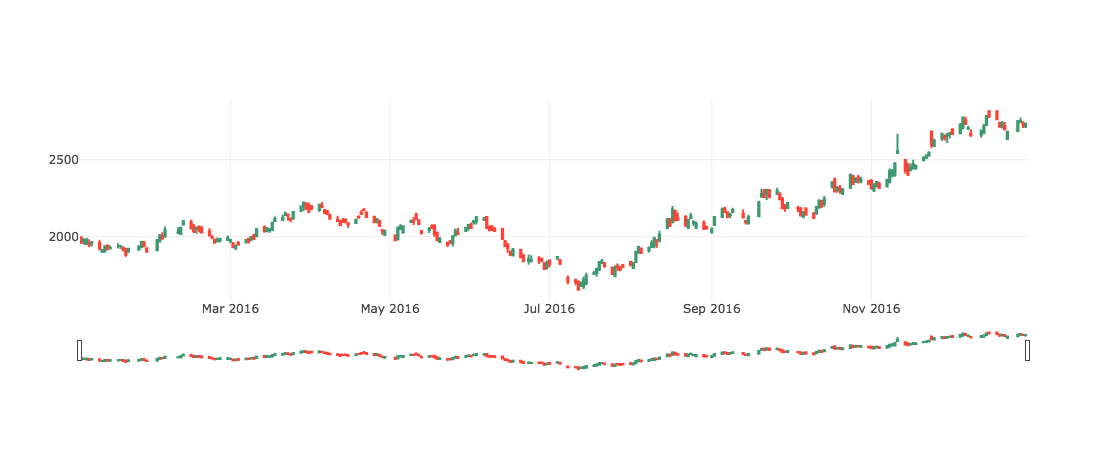

In [24]:
cndl_trace=go.Candlestick(x=selected_fcpo_data.index,
            open=selected_fcpo_data.Open,
            close=selected_fcpo_data.Close,
            high=selected_fcpo_data.High,
            low=selected_fcpo_data.Low)
iplot([cndl_trace])

### Candle stick patterns

CDLRICKSHAWMAN

CDLLONGLEGGEDDOJI

CDLHARAMI

CDLSPINNINGTOP

CDLMARUBOZU

CDLLONGLINE

CDLHIKKAKE

CDLHIGHWAVE

CDLENGULFING

CDLDOJI

CDLCLOSINGMARUBOZU

CDLBELTHOLD

### FCPO Profit Indicators

In [10]:
fcpo_data_daily['2007-01-01':'2016-01-01'].groupby(['lprofit_ind','sprofit_ind'])['Close'].count()

lprofit_ind  sprofit_ind
0            0               87
             1              767
1            0              746
             1              505
Name: Close, dtype: int64

In [11]:
fcpo_data_daily['2016-01-01':'2017-01-01'].groupby(['lprofit_ind','sprofit_ind'])['Close'].count()

lprofit_ind  sprofit_ind
0            0               1
             1              87
1            0              96
             1              62
Name: Close, dtype: int64